In [26]:
import pandas as pd
pd.set_option("display.max_columns", 150)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer




In [2]:
citibike = pd.read_csv('../data/citibike_vis.csv')
citibike  = citibike.drop(columns = 'Unnamed: 0') #dropping extra column
citibike = citibike.sort_values('date').reset_index(drop = True) #sorting the values by date and resetting index.

In [3]:
citibike['date'] = pd.to_datetime(citibike['date'])
citibike['day_of_week'] = citibike['day_of_week'].astype(str) #changing the day of week column to string.

In [4]:
linreg = LinearRegression()

In [5]:
citibike.columns

Index(['date', 'num_of_trips', 'holiday', 'prcp', 'snow', 'awnd', 'rhav',
       'rhmn', 'rhmx', 'tmax', 'tmin', 'tavg', 'median_trip_duration',
       'mean_trip_duration', 'day_of_week', 'year', 'month', 'is_snow',
       'did_rain', 'season', 'event_happened'],
      dtype='object')

In [6]:
predictors = ['tmax']

X = citibike[predictors]
y = citibike['num_of_trips'] 

#splitting the X and y varibles for training and testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 117)

linreg_temp = linreg.fit(X_train, y_train)
y_pred = linreg_temp.predict(X_test)

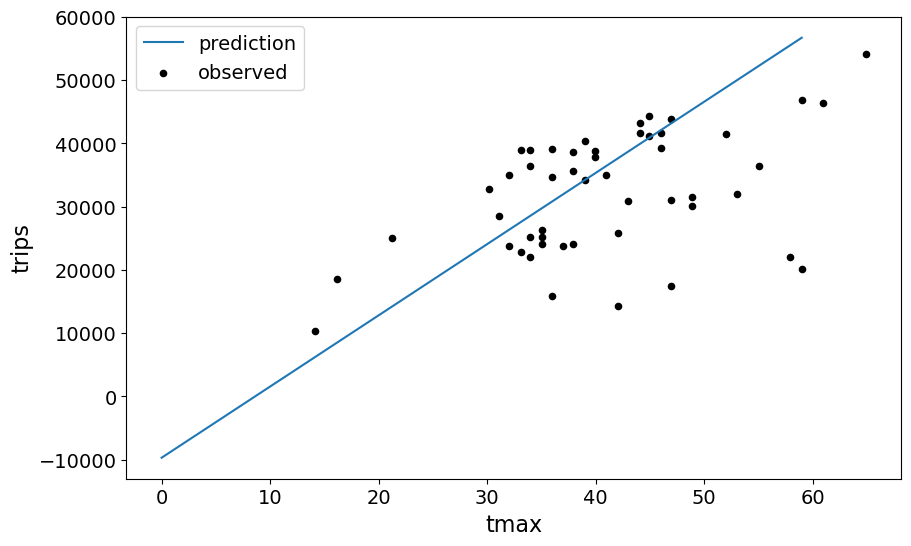

In [7]:
x_grid = np.linspace(start = 0, stop = np.max(citibike['tmax'].head(25)))
x_grid = pd.DataFrame({
    'tmax': x_grid
})
y_grid = linreg.predict(x_grid)

fontsize = 16

fig, ax = plt.subplots(figsize = (10,6))


plt.plot(x_grid, y_grid, label = 'prediction')

citibike.head(50).plot(kind = 'scatter',
                    x = 'tmax',
                    y = 'num_of_trips',
                    ax = ax,
                    color = 'black',
                    label = 'observed')

plt.legend(fontsize = fontsize - 2)


plt.xlabel('tmax', fontsize = fontsize)
plt.ylabel('trips', fontsize = fontsize)
plt.xticks(fontsize = fontsize - 2)
plt.yticks(fontsize = fontsize - 2);

In [8]:
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
print(r2_score(y_test, y_pred))
print(y_test.std())

391875904.54565287
15413.98201547318
0.4938316460514631
27875.37660768082


In [9]:
citibike.head(1)

,date,num_of_trips,holiday,prcp,snow,awnd,rhav,rhmn,rhmx,tmax,tmin,tavg,median_trip_duration,mean_trip_duration,day_of_week,year,month,is_snow,did_rain,season,event_happened
0,2019-01-01,21962,True,15,0.0,NaN,69.0,47.0,97.0,57.92,39.02,48.47,663.0,1175.93,1,2019,1,False,True,Winter,False


In [13]:
citibike.isnull().sum()

date                      0
num_of_trips              0
holiday                   0
prcp                      0
snow                      0
awnd                    123
rhav                     11
rhmn                     11
rhmx                     11
tmax                      0
tmin                      0
tavg                      0
median_trip_duration      0
mean_trip_duration        0
day_of_week               0
year                      0
month                     0
is_snow                   0
did_rain                  0
season                    0
event_happened            0
dtype: int64

In [20]:
predictors = ['tmax', 'is_snow', 'did_rain', 'day_of_week', 'holiday', 'season', 'month', 'awnd', 'rhav', 'rhmn', 'rhmx', 'tavg', 'event_happened']
cat_predictors = ['is_snow', 'did_rain', 'day_of_week', 'holiday', 'season', 'month', 'event_happened']
num_predictors = ['tmax', 'rhav', 'rhmn', 'rhmx', 'tavg', 'awnd']

X = citibike[predictors]
X = pd.get_dummies(X, columns = cat_predictors)
y = citibike['num_of_trips']

# Splitting the X and y variables for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=117)

# Creating the scaler and imputer
scaler = StandardScaler()
iterative_imputer = IterativeImputer()

# Fit the scaler and imputer on the training set
X_train_num = scaler.fit_transform(X_train[num_predictors])
X_train_num = iterative_imputer.fit_transform(X_train_num)

# Apply the same transformations to the test set
X_test_num = scaler.transform(X_test[num_predictors])
X_test_num = iterative_imputer.transform(X_test_num)

X_train.loc[:, num_predictors] = X_train_num
X_test.loc[:, num_predictors] = X_test_num

#linear regression model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predict on the test set
y_pred_all = linreg.predict(X_test)


/Users/kd/anaconda3/lib/python3.10/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [21]:
print(f'MSE: {mean_squared_error(y_test, y_pred_all)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_all)}')
print(f'R^2: {r2_score(y_test, y_pred_all)}')
print(f'std: {y_test.std()}')

MSE: 250510726.84854016
MAE: 12232.689781021898
R^2: 0.6764266422494343
std: 27875.37660768082


In [ ]:
citibike

In [22]:
predictors = ['tmax','is_snow', 'did_rain', 'day_of_week', 'holiday', 'season', 'month']
cat_predictors = ['is_snow', 'did_rain', 'day_of_week', 'holiday', 'season', 'month']

X = citibike[predictors]
X = pd.get_dummies(X, columns = cat_predictors)
y = citibike['num_of_trips'] 

#splitting the X and y varibles for training and testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 117)

linreg_all = linreg.fit(X_train, y_train)
y_pred_all = linreg_all.predict(X_test)

In [23]:
print(f'MSE: {mean_squared_error(y_test, y_pred_all)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_all)}')
print(f'R^2: {r2_score(y_test, y_pred_all)}')
print(f'std: {y_test.std()}')

MSE: 283599240.10512
MAE: 13094.82811718474
R^2: 0.6336877085834165
std: 27875.37660768082


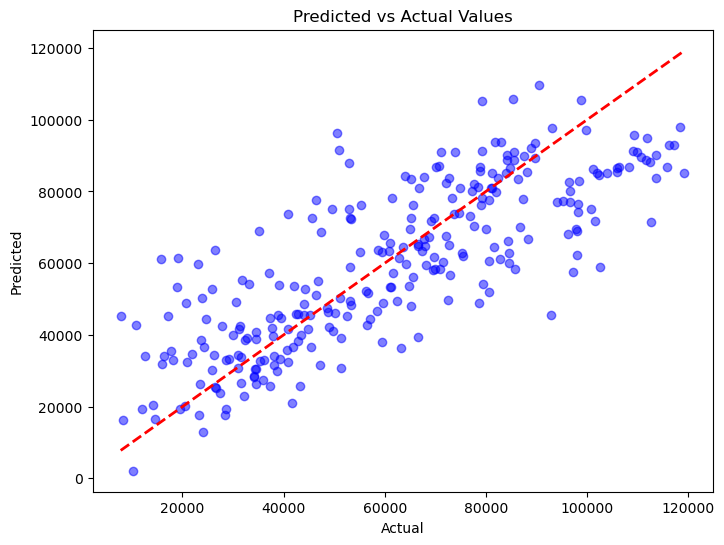

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_all, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual Values')
plt.show()